In [1]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

2025-02-08 14:02:42.754062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 14:02:43.670026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-08 14:02:43.670170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-08 14:02:43.670180: W tensorflow/compiler/tf2tensorrt/util

产生数据

In [2]:
raw_num = 240
col_num = 2000

class Data(object):
    
    def __init__(self):
        self.data = self.get_data()
        self.label = self.get_label()
        
    def file_list(self):
        return os.listdir('data/')
    
    def get_data(self):
        file_list = self.file_list()
        for i in range(len(file_list)):
            file = scio.loadmat('data/{}'.format(file_list[i]))
            for k in file.keys():
                file_matched = re.match('X\d{3}_DE_time', k)
                if file_matched:
                    key = file_matched.group()
            if i == 0:
                data = np.array(file[key][0:480000].reshape(raw_num,col_num))
            else:
                data = np.vstack((data, file[key][0:480000].reshape((raw_num,col_num))))
        return data
    
    def get_label(self):
        file_list = self.file_list()
        title = np.array([i.replace('.mat', '') for i in file_list])
        label = title[:, np.newaxis]
        label_copy = np.copy(label)
        for _ in range(raw_num-1):
            label = np.hstack((label, label_copy))
        return label.flatten()

In [3]:
Data = Data()
data = Data.data
label = Data.label
lb = LabelBinarizer()
y = lb.fit_transform(label)

In [12]:
data.shape, y.shape

((2400, 2000), (2400, 10))

In [6]:
# Wiener filtering
data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)

In [7]:
data_wiener.shape

(2400, 2000)

In [10]:
# downsampling
index = np.arange(0,2000, 8)
data_samp = data_wiener[:, index]
print(data_samp.shape)

(2400, 250)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1680, 250), (720, 250), (1680, 10), (720, 10))

In [10]:
def built_model():
    
    input_seq = Input(shape=(250,))
    X = Reshape((1,250))(input_seq)
    
    # encoder1
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh',
                      data_format='channels_first')(ec1_layer1)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec1_layer2)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh',
                      data_format='channels_first')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(ec2_layer4)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec2_layer5)
    
    encoder = multiply([ec1_outputs, ec2_outputs])
    
    dc_layer1 = LSTM(60, return_sequences=True)(encoder)
    dc_layer2 = LSTM(60)(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)
    
    model = Model(input_seq, dc_layer4)
    
    return model

In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [12]:
import time
begain_time = time.time()

In [13]:
model = built_model()
opt = Adam(lr=0.0006)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

2025-02-08 13:51:34.364853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 13:51:34.461378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 13:51:34.461708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 13:51:34.463124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 250)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 50, 245)      350         ['reshape[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 40, 240)      12040       ['conv1d_2[0][0]']               
                                                                                              

/home/kycho/vad-code/.conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=400, 
                    verbose=2, validation_data=(X_test, y_test),
                    shuffle=True, initial_epoch=0)

Epoch 1/400


2025-02-08 13:51:47.717938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


17/17 - 15s - loss: 0.0898 - accuracy: 0.1375 - val_loss: 0.0887 - val_accuracy: 0.1125 - 15s/epoch - 859ms/step
Epoch 2/400
17/17 - 0s - loss: 0.0855 - accuracy: 0.1464 - val_loss: 0.0819 - val_accuracy: 0.1972 - 196ms/epoch - 12ms/step
Epoch 3/400
17/17 - 0s - loss: 0.0811 - accuracy: 0.2048 - val_loss: 0.0802 - val_accuracy: 0.2014 - 194ms/epoch - 11ms/step
Epoch 4/400
17/17 - 0s - loss: 0.0794 - accuracy: 0.2143 - val_loss: 0.0783 - val_accuracy: 0.2306 - 196ms/epoch - 12ms/step
Epoch 5/400
17/17 - 0s - loss: 0.0765 - accuracy: 0.2839 - val_loss: 0.0736 - val_accuracy: 0.3014 - 195ms/epoch - 11ms/step
Epoch 6/400
17/17 - 0s - loss: 0.0718 - accuracy: 0.3304 - val_loss: 0.0687 - val_accuracy: 0.3764 - 194ms/epoch - 11ms/step
Epoch 7/400
17/17 - 0s - loss: 0.0672 - accuracy: 0.3905 - val_loss: 0.0666 - val_accuracy: 0.3903 - 195ms/epoch - 11ms/step
Epoch 8/400
17/17 - 0s - loss: 0.0673 - accuracy: 0.3964 - val_loss: 0.0631 - val_accuracy: 0.4667 - 193ms/epoch - 11ms/step
Epoch 9/400


In [ ]:
#end_time = time.time()
#time = end_time - begain_time
#print('time:', time)

23/23 [==============================] - 1s 5ms/step


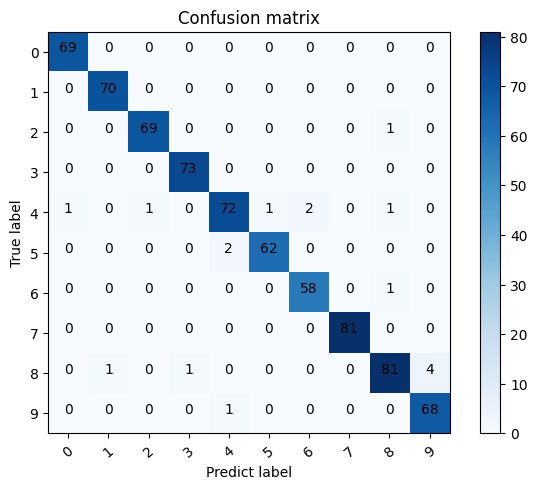

In [15]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))